
# Clinical Trials NLP — EDA & Results

This notebook summarizes the dataset and results for the **Clinical Trials NLP** project.
It is designed so **user can render everything without running**—after you run the cells once locally and save the notebook with outputs.

**What you'll see here:**
- Basic dataset stats (trials, endpoints, coverage)
- Phase distribution
- A few example trials with extracted endpoints
- Data preprocessing and cleaning
- Training and evaluating
- Figures saved to `clinical-trials-nlp/reports/`



In [1]:
import os, json, re, collections
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Paths relative to repo root (adjust if needed)
ROOT = Path.cwd().parent
DATA = ROOT / "data"
REPORTS = ROOT / "reports"

TRIALS_PATH = DATA / "trials.jsonl"
ENDPOINTS_PATH = DATA / "endpoints.jsonl"

REPORTS.mkdir(parents=True, exist_ok=True)

print("Using:")
print("  TRIALS  :", TRIALS_PATH)
print("  ENDPOINTS:", ENDPOINTS_PATH)
print("  REPORTS :", REPORTS)


/Users/zina/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/zina/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Using:
  TRIALS  : /Users/zina/Desktop/upwork_data_science_portfolio/clinical-trials-nlp/data/trials.jsonl
  ENDPOINTS: /Users/zina/Desktop/upwork_data_science_portfolio/clinical-trials-nlp/data/endpoints.jsonl
  REPORTS : /Users/zina/Desktop/upwork_data_science_portfolio/clinical-trials-nlp/reports


In [28]:

# Load trials and endpoints jsonl
import json
def read_jsonl(p):
    rows = []
    with open(p, "r", encoding="utf-8") as f:
        for line in f:
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                pass
    return pd.DataFrame(rows)

df_trials = read_jsonl(TRIALS_PATH)
df_endp = read_jsonl(ENDPOINTS_PATH)

print("Trials file rows:", len(df_trials))
print("Endpoints file rows:", len(df_endp))

# merge to one table

key = "nct_id" if ("nct_id" in df_trials.columns and "nct_id" in df_endp) else "title"

if df_endp.duplicated(subset=[key]).any():
    df_endp = (df_endp
                    .groupby(key, as_index=False)["extracted_endpoints"]
                    .apply(lambda s: sum((x if isinstance(x, list) else [x] for x in s), []))
                    .reset_index(drop=True))

cols_to_add = [c for c in ["extracted_endpoints", "primary_outcomes", "secondary_outcomes"] if c in df_endp.columns]
df_add = df_endp[[key] + cols_to_add].copy()

df = df_trials.merge(df_add, on=key, how="left")

for c in cols_to_add:
    if c in df.columns:
        df[c] = df[c].apply(lambda x: x if isinstance(x, list) else ([] if pd.isna(x) else [x]))

df.head(10)


Trials file rows: 2000
Endpoints file rows: 2000


,nct_id,title,brief_summary,phase,condition,study_type,extracted_endpoints
0,NCT02087176,A Placebo Controlled Study Comparing AZD1775+ ...,"A Lead-in Phase II Multicentre, Randomised, Do...",PHASE2,Previously Treated Non Small Cell Lung Cancer,INTERVENTIONAL,[]
1,NCT05512676,Trabectedin/Caelyx vs Cisplatin Hypersensitivi...,"Observational, clinical study. Intention to in...",None,Ovarian Neoplasm,OBSERVATIONAL,[]
2,NCT03146117,PET-DECT for Staging and Imaged Based Radiothe...,The overall goal of this project is to investi...,None,PET CT,OBSERVATIONAL,[]
3,NCT03272217,Atezolizumab With Bevacizumab in Previously Un...,This is a phase II study assessing the activit...,PHASE2,Urothelial Carcinoma,INTERVENTIONAL,[]
4,NCT06706076,A Study of BH-30643 in Subjects With Locally A...,"BH-30643-01 is a Phase 1/2, first-in-human, op...",PHASE1,NSCLC (Advanced Non-small Cell Lung Cancer),INTERVENTIONAL,[]
5,NCT01865617,Laboratory Treated T Cells in Treating Patient...,This phase I/II trial studies the side effects...,PHASE1,CD19-Positive Neoplastic Cells Present,INTERVENTIONAL,[]
6,NCT04473040,Managed Access Program to Provide Access to Al...,The purpose of this Cohort Treatment Plan is t...,None,"HR+, HER2-, Advanced Breast Cancer",EXPANDED_ACCESS,[]
7,NCT07037589,Women With isoLated acUte cyStitis and Macrosc...,This prospective multicenter observational stu...,None,Hematuria,OBSERVATIONAL,[is to identify low-risk patients where invasi...
8,NCT02404389,"Safety, Tolerability, and Efficacy Study of LF...","This is a randomized, vehicle controlled, acti...",PHASE2,Actinic Keratosis,INTERVENTIONAL,[]
9,NCT04666168,A Multicenter Clinical Study on the Safety and...,"This study is a multicenter, non randomized, s...",NA,Non-hodgkin's Lymphoma,INTERVENTIONAL,[]


It is absolutely normal to don't have enough endpoints extracted. It can be treated by implementing transformers or spaCy to understand semantics better, because for now we have only regex scanning here. 

In [7]:
# Basic stats
n_trials = len(df)
n_with_endp = int(df["extracted_endpoints"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) > 0).sum())
coverage = n_with_endp / n_trials if n_trials else 0.0

print(f"Trials: {n_trials}")
print(f"With endpoints: {n_with_endp} ({coverage:.1%})")

# Phase distribution
phase_col_candidates = [c for c in df.columns if c.lower().endswith("phase")]
phase_col = phase_col_candidates[0] if phase_col_candidates else "phase"
df[phase_col] = df[phase_col].astype(str).str.upper().str.strip()
phase_counts = df[phase_col].value_counts()
phase_counts


Trials: 2000
With endpoints: 987 (49.4%)


phase
PHASE2          488
NONE            454
NA              450
PHASE1          399
PHASE3          124
PHASE4           61
EARLY_PHASE1     24
Name: count, dtype: int64

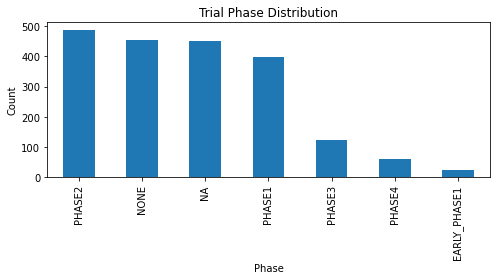

Saved: /Users/zina/Desktop/upwork_data_science_portfolio/clinical-trials-nlp/reports/fig_phase_distribution.png


In [8]:
# Plot phase distribution
plt.figure(figsize=(7,4))
phase_counts.plot(kind="bar")
plt.title("Trial Phase Distribution")
plt.xlabel("Phase")
plt.ylabel("Count")
fig_path1 = REPORTS / "fig_phase_distribution.png"
plt.tight_layout()
plt.savefig(fig_path1, dpi=160)
plt.show()
print("Saved:", fig_path1)


In [ ]:
# Show a few example trials with endpoints
examples = df[df["extracted_endpoints"].apply(lambda x: isinstance(x, (list, tuple)) and len(x)>0)].head(5)
examples[["nct_id" if "nct_id" in examples.columns else examples.columns[0], "title", phase_col, "extracted_endpoints"]]


,nct_id,title,phase,extracted_endpoints
7,NCT07037589,Women With isoLated acUte cyStitis and Macrosc...,NONE,[is to identify low-risk patients where invasi...
10,NCT04013568,Exercise Post-Diagnosis of Breast Cancer,NA,[if there are body composition changes after a...
11,NCT06766591,Ivonescimab Combined With Chemotherapy for the...,NA,[* iPFS (intracranial progression free surviva...
12,NCT01535391,"Nilotinib in PH+, BCR-, ABL+ CML Patients",PHASE3,[of the trial is to evaluate the efficacy of n...
15,NCT07066813,Staging Strategies and Their Association With ...,NONE,[the most accurate tumor size measurement meth...


In [29]:
replace_map = {
            "NONE": pd.NA,
            "NA": pd.NA,
            "PHASE2" : "PHASE 2",
            "PHASE1" : "PHASE 1",
            "PHASE3" : "PHASE 3",
            "PHASE4" : "PHASE 4",
            "EARLY_PHASE1" : "PHASE 1"
}

df['phase_clean'] = (
                        df['phase']
                        .astype("string")
                        .str.upper().str.strip()
                        .replace(replace_map)
)

df['phase'] = df["phase_clean"]

print(df['phase'].value_counts(dropna=False))

phase
<NA>       904
PHASE 2    488
PHASE 1    423
PHASE 3    124
PHASE 4     61
Name: count, dtype: Int64


phase
PHASE 2    488
PHASE 1    423
PHASE 3    124
PHASE 4     61
Name: count, dtype: Int64

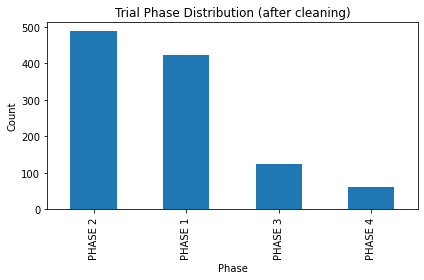

Saved: /Users/zina/Desktop/upwork_data_science_portfolio/clinical-trials-nlp/reports/phase_dist_2.png


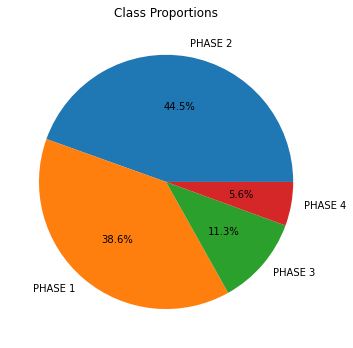

Saved: /Users/zina/Desktop/upwork_data_science_portfolio/clinical-trials-nlp/reports/pie.png


In [57]:
vc = df['phase'].value_counts().sort_values(ascending=False)
display(vc)

plt.figure(figsize=(6,4))
vc.plot(kind="bar")
plt.title("Trial Phase Distribution (after cleaning)")
plt.xlabel("Phase")
plt.ylabel("Count")
fig_path2 = REPORTS / "phase_dist_2.png"
plt.tight_layout()
plt.savefig(fig_path2, dpi=160)
plt.show()
print("Saved:", fig_path2)

# class proportion pie (optional)
plt.figure(figsize=(5,5))
vc.plot(kind="pie", autopct="%1.1f%%")
plt.ylabel("")
plt.title("Class Proportions")
fig_path3 = REPORTS / "pie.png"
plt.tight_layout()
plt.savefig(fig_path3, dpi=160)
plt.show()
print("Saved:", fig_path3)

We can see here a solid class imbalance - phase I and II take precedence over phase I and IV. Moreover, more around 50% of dataset is NA. 

In [55]:
X = df['brief_summary'].fillna("").astype("string").str.strip().to_numpy()
y = df['phase'].fillna("").astype("string").str.strip().to_numpy()

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

X = df['brief_summary'].astype(str).str.strip()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
                    ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2))),
                    ("clf", LogisticRegression(max_iter=300))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

                  0.735     0.950     0.829       181
     PHASE 1      0.773     0.600     0.675        85
     PHASE 2      0.610     0.629     0.619        97
     PHASE 3      0.000     0.000     0.000        25
     PHASE 4      0.000     0.000     0.000        12

    accuracy                          0.710       400
   macro avg      0.424     0.436     0.425       400
weighted avg      0.645     0.710     0.669       400



/Users/zina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zina/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
